## Kaggle competition - Predict Future Sales

### Read me
Training data and model objects are serialised, load dependencies first then just run from step 3.7 to skip the steps that create the training dataset.

### 0. Loading Dependencies

In [67]:
import numpy
import catboost
import pandas
import seaborn
import sklearn
import xgboost
import statsmodels

In [68]:
packages = [numpy, catboost, pandas, seaborn, sklearn, xgboost, statsmodels]
for package in packages:
    print(f'{package.__name__} {package.__version__}')

numpy 1.19.2
catboost 0.24.1
pandas 1.1.2
seaborn 0.11.0
sklearn 0.23.2
xgboost 1.2.0
statsmodels 0.12.0


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import pickle
import pandas as pd
import numpy as np
import PyQt5
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs
from itertools import product
import gc

from pylab import rcParams
import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time

from catboost import *
import catboost
from catboost import Pool
from catboost import CatBoostClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
# %matplotlib qt

### 1. Loading data

In [2]:
# Create a function to downcast data to save storage
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe:

                `float64` type to `float32`
                `int64`   type to `int32`
    '''

    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]

    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)

    return df

In [3]:
DATA_FOLDER = '/Users/linding/github/Coursera/Advanced machine learning - Kaggle/Final project'
os.chdir(DATA_FOLDER)

trans           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

test           = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz')).set_index('ID')

In [4]:
# The time series range
print('Timeseries start from ' + str(trans['date'].min()) + ', finish on ' + str(trans['date'].max()))

Timeseries start from 01.01.2013, finish on 31.12.2014


### 2. EDA

Text(11.5, 180000, 'Spike on sales towards the end of the year')

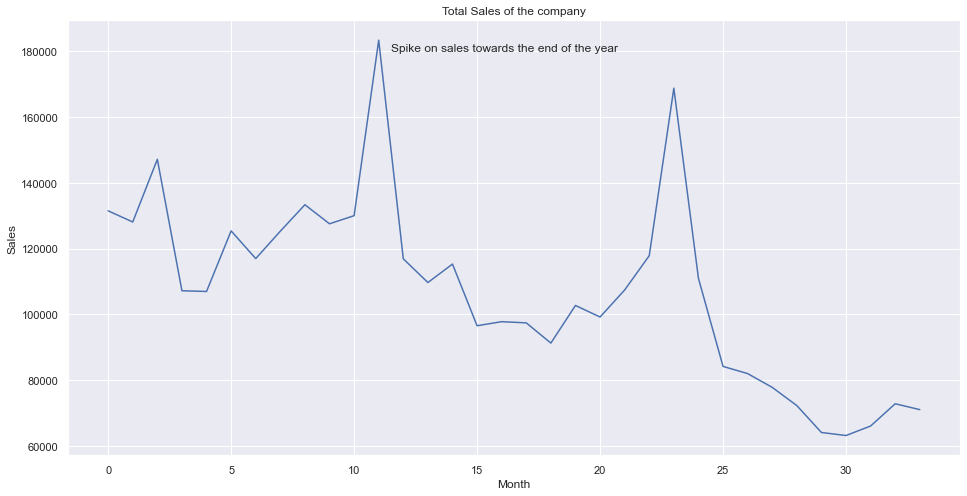

In [5]:
ts=trans.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.plot(ts);
plt.text(11.5,180000,'Spike on sales towards the end of the year')

In [6]:
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
trans = pd.merge(trans, item_category_mapping, how='left', on='item_id')

In [7]:
# Sales by item category
gp_category_mean = trans.groupby(['item_category_id'], as_index=False)['item_cnt_day'].mean()
gp_category_sum = trans.groupby(['item_category_id'], as_index=False)['item_cnt_day'].sum()

# Sales by shop
gp_shop_mean = trans.groupby(['shop_id'], as_index=False)['item_cnt_day'].mean()
gp_shop_sum = trans.groupby(['shop_id'], as_index=False)['item_cnt_day'].sum()

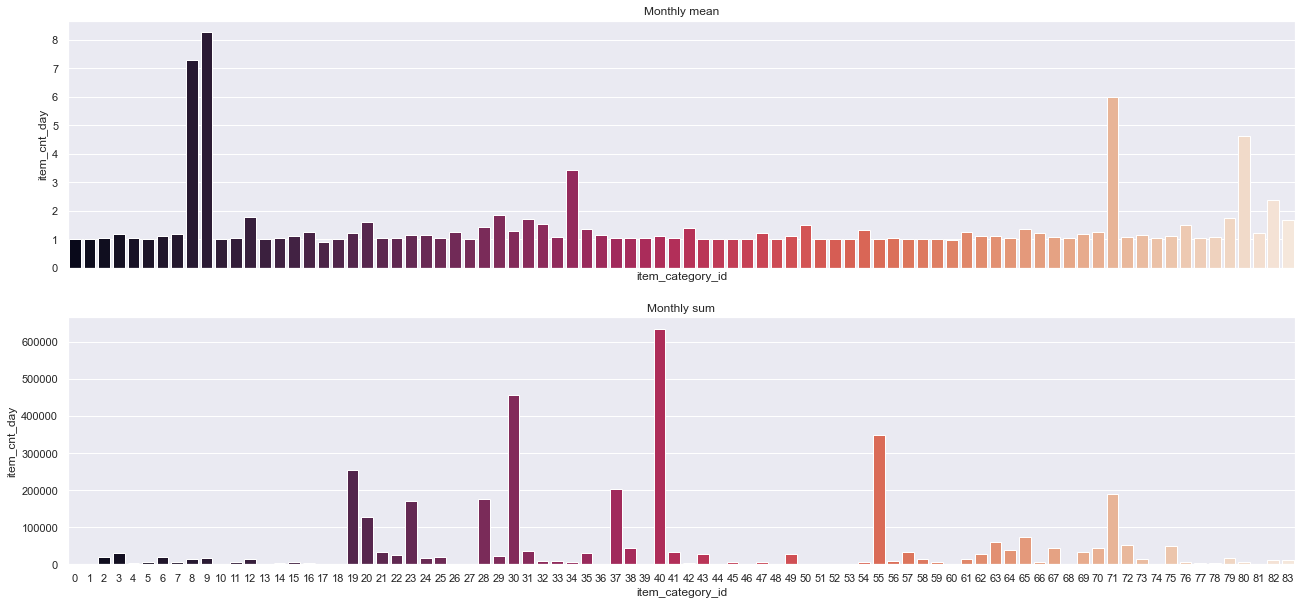

In [8]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt_day", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt_day", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

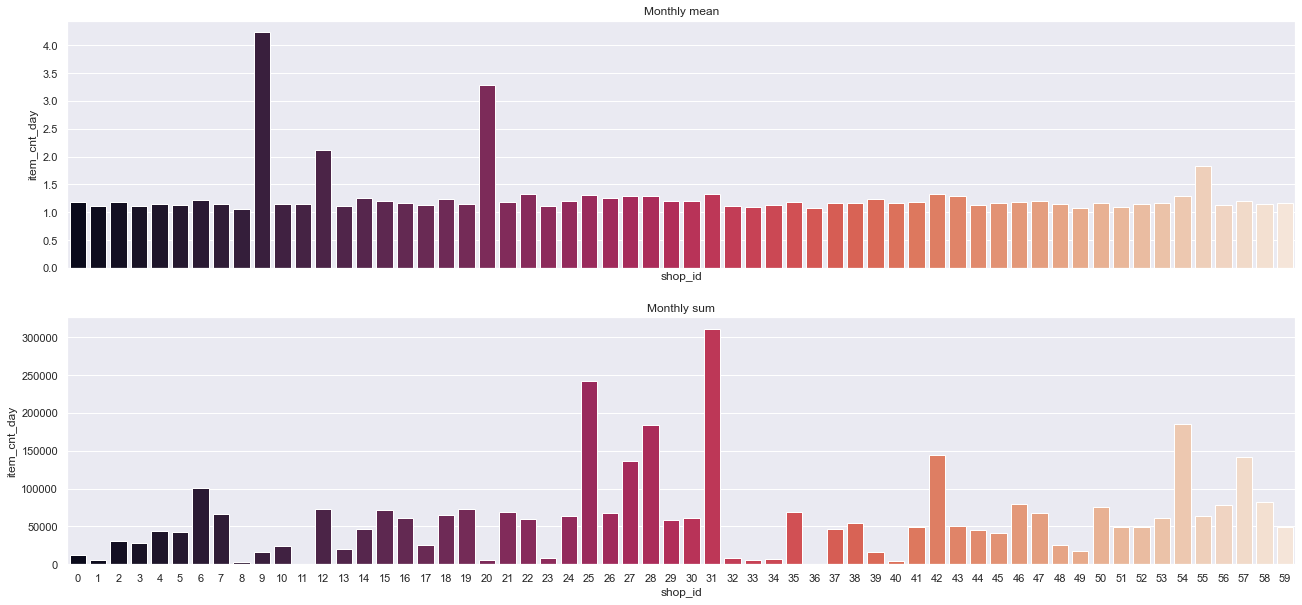

In [9]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt_day", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt_day", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

## 3. Data pre-processing

### 3.1 Removing outliers

<AxesSubplot:xlabel='item_price'>

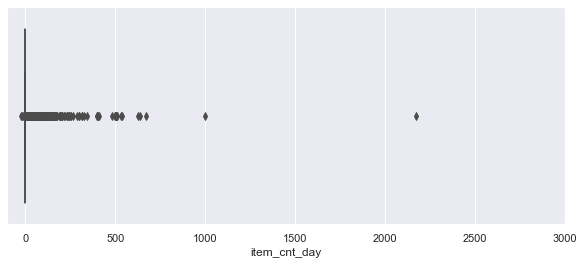

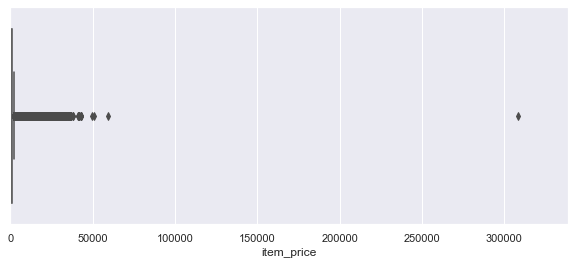

In [10]:
# Checking for outliers
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=trans.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(trans.item_price.min(), trans.item_price.max()*1.1)
sns.boxplot(x=trans.item_price)

In [11]:
# Removing outliers
trans = trans[trans.item_price<100000]
trans = trans[trans.item_cnt_day<1001]

In [12]:
trans['item_price'].min()

-1.0

In [13]:
trans[trans['item_price'] < 0]

date  date_block_num  shop_id  item_id  item_price  \
484683  15.05.2013               4       32     2973        -1.0   

        item_cnt_day  item_category_id  
484683           1.0                19

In [14]:
# One item with negative price, fill with median
median = trans[(trans.shop_id==32)&(trans.item_id==2973)&(trans.date_block_num==4)&(trans.item_price>0)].item_price.median()
trans.loc[trans.item_price<0, 'item_price'] = median

In [15]:
# Several duplicated shops, fix both train and test
trans.loc[trans.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

trans.loc[trans.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

trans.loc[trans.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

### 3.2 Creating a matrix with target

In [16]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = trans[trans.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [17]:
group = trans.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

In [18]:
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

In [19]:
matrix.head()

date_block_num  shop_id  item_id  item_cnt_month
0               0        2       19             0.0
1               0        2       27             1.0
2               0        2       28             0.0
3               0        2       29             0.0
4               0        2       32             0.0

### 3.3 Creating test dataset and stack on top of the training data

In [20]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month

In [21]:
matrix

date_block_num  shop_id  item_id  item_cnt_month
0                      0        2       19             0.0
1                      0        2       27             1.0
2                      0        2       28             0.0
3                      0        2       29             0.0
4                      0        2       32             0.0
...                  ...      ...      ...             ...
11127999              34       45    18454             0.0
11128000              34       45    16188             0.0
11128001              34       45    15757             0.0
11128002              34       45    19648             0.0
11128003              34       45      969             0.0

[11128004 rows x 4 columns]

In [22]:
# Item/Shop/Category features
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
# if subtype is nan then type
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

trans['revenue'] = trans['item_price'] * trans['item_cnt_day']

In [23]:
# Merging additional features into training data
matrix = pd.merge(matrix, item_category_mapping, on='item_id', how='left')
matrix = pd.merge(matrix, shops, on='shop_id', how='left')
matrix = pd.merge(matrix, item_categories, on='item_category_id', how='left')

Feature with month and number of days in each month.

In [24]:
matrix['month'] = matrix['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31], index=range(0, 12))
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [25]:
matrix = downcast_dtypes(matrix)

In [26]:
matrix.head()

date_block_num  shop_id  item_id  item_cnt_month  item_category_id  \
0               0        2       19             0.0                40   
1               0        2       27             1.0                19   
2               0        2       28             0.0                30   
3               0        2       29             0.0                23   
4               0        2       32             0.0                40   

   city_code  type_code  subtype_code  month  days  
0          0         11             4      0    31  
1          0          5            10      0    31  
2          0          8            55      0    31  
3          0          5            16      0    31  
4          0         11             4      0    31

### 3.4 Mean encoding

In [27]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [28]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

Monthly average

In [29]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

Monthly average per item

In [30]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

Monthly average per shop

In [31]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

Monthly average per category

In [32]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

Monthly average per shop category

In [33]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

Monthly average per type shop

In [34]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

Monthly average per subtype & shop

In [35]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

Monthly average per city

In [36]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

Monthly average per city item

In [37]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

Monthly average per item type

In [38]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

Monthly average per subtype item

In [39]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

### 3.5 Trend features

In [40]:
group = trans.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

# Average price in each month for each item
group = trans.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

In [41]:
features_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    features_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    features_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(features_to_drop, axis=1, inplace=True)

# Last month shop revenue trend
group = trans.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)


### 3.6 Other features

In [42]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num

cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num

# Months since the first sale for each shop/item pair and for item only.
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

### 3.7 Feature Selection & Train/validation Split

Only selecting data with date_block_num >= 11 to avoid missing value generated by lag features

In [43]:
matrix = matrix[matrix.date_block_num > 11]

Fill missing values with 0

In [44]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
    return df

matrix = fill_na(matrix)

Serialize data

In [45]:
matrix.to_pickle('data.pkl')

In [46]:
# Delete redundant tables to free memory
del matrix
del cache
del group
del items
del shops
del train
gc.collect();

In [47]:
data = pd.read_pickle('data.pkl')
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    # 'date_shop_type_avg_item_cnt_lag_1',
    # 'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    # 'date_type_avg_item_cnt_lag_1',
    # 'date_subtype_avg_item_cnt_lag_1',
    # 'delta_revenue_lag_1', # just added
    'delta_price_lag',
    # 'year', # just added
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

Train/test split

In [48]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month'].astype('float32')
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month'].astype('float32')
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

int_features = ['shop_id', 'item_id', 'month', 'item_category_id', 'city_code', 'type_code', 'subtype_code']

## 4. Model training

### 4.1 XGBoost

In [49]:
xgb_model = XGBRegressor(
    max_depth=8,
    n_estimators=800,
    min_child_weight=300,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.3,
    seed=42)

xgb_model.fit(
    X_train,
    Y_train,
    eval_metric="rmse",
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
    verbose=True,
    early_stopping_rounds = 10)

xgb_val_pred = xgb_model.predict(X_valid).clip(0, 20)
xgb_test_pred = xgb_model.predict(X_test).clip(0, 20)
xgb_train_pred = xgb_model.predict(X_train).clip(0, 20)

print('Train rmse by xgboost:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse by xgboost:', np.sqrt(mean_squared_error(Y_valid, xgb_val_pred)))

[15:53:51] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.05064	validation_1-rmse:1.03997
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.96054	validation_1-rmse:0.97632
[2]	validation_0-rmse:0.91184	validation_1-rmse:0.94261
[3]	validation_0-rmse:0.88454	validation_1-rmse:0.92826
[4]	validation_0-rmse:0.86592	validation_1-rmse:0.92001
[5]	validation_0-rmse:0.85242	validation_1-rmse:0.91462
[6]	validation_0-rmse:0.84423	validation_1-rmse:0.91072
[7]	validation_0-rmse:0.83830	validation_1-rmse:0.90894
[8]	validation_0-rmse:0.83464	validation_1-rmse:0.90904
[9]	validation_0-rmse:0.83195	validation_1-rmse:0.90928
[10]	validation_0-rmse:0.83012	validation_

In [50]:
# Save model object
pkl_filename = "xgb_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgb_model, file)

### 4.2 Catboost

In [51]:
X_train[int_features] = X_train[int_features].astype('int32')
X_valid[int_features] = X_valid[int_features].astype('int32')
X_test[int_features] = X_test[int_features].astype('int32')

pool = Pool(data=X_train, label=Y_train)
print(pool.get_feature_names())

cat_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=7,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=7
)

cat_model.fit(
    X_train, Y_train,
    cat_features=int_features,
    eval_set=(X_valid, Y_valid)
)

catboost_train_pred = cat_model.predict(X_train).clip(0, 20)
catboost_val_pred = cat_model.predict(X_valid).clip(0, 20)
catboost_test_pred = cat_model.predict(X_test).clip(0, 20)

print('Train rmse by catboost:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse by catboost:', np.sqrt(mean_squared_error(Y_valid, catboost_val_pred)))

['date_block_num', 'shop_id', 'item_id', 'city_code', 'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1', 'date_item_city_avg_item_cnt_lag_1', 'delta_price_lag', 'month', 'days', 'item_shop_last_sale', 'item_last_sale', 'item_shop_first_sale', 'item_first_sale']
Learning rate set to 0.369503
0:	learn: 1.0424113	test: 1.0343232	best: 1.0343232 (0)	total: 3.76s	remaining: 31m 17s
Stopped by overfitting detector  (25 iterations wait)

In [52]:
# Save model object
pkl_filename = "cat_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(cat_model, file)

### 4.3 Random Forest

In [53]:
rf_model = RandomForestRegressor(n_estimators=50,
                                 max_depth=10,
                                 random_state=0,
                                 n_jobs=-1)
rf_model.fit(X_train, Y_train)


rf_train_pred = rf_model.predict(X_train).clip(0, 20)
rf_val_pred = rf_model.predict(X_valid).clip(0, 20)
rf_test_pred = rf_model.predict(X_test).clip(0, 20)

print('Train rmse by random forest:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse by random forest:', np.sqrt(mean_squared_error(Y_valid, rf_val_pred)))

Train rmse by random forest: 0.8153377994180993
Validation rmse by random forest: 0.9287416691037621


In [54]:
# Save model object
pkl_filename = "rf_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf_model, file)

### 4.5 Ridge Regression

In [56]:
model = Ridge()
# Find best alpha with cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.1)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
ridge_model = search.fit(X_train, Y_train)

ridge_train_pred = ridge_model.predict(X_train).clip(0, 20)
ridge_val_pred = ridge_model.predict(X_valid).clip(0, 20)
ridge_test_pred = ridge_model.predict(X_test).clip(0, 20)

print('Train rmse by Ridge Regression:', np.sqrt(mean_squared_error(Y_train, ridge_train_pred)))
print('Validation rmse by Ridge Regression:', np.sqrt(mean_squared_error(Y_valid, ridge_val_pred)))

Train rmse by Ridge Regression: 0.9157798508233309
Validation rmse by Ridge Regression: 0.9627769236450069


In [57]:
# Save model object
pkl_filename = "ridge_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(search, file)

## 5. Ensemble
Use XGboost, catboost, random forest and Ridge Regression as the first level models.

Load model objects if not running from beginning

In [58]:
models = ['xgb', 'cat', 'rf', 'ridge']
model_set = {}
for model in models:
    pkl_filename = model + '_model.pkl'
    with open(pkl_filename, 'rb') as file:
        model_set[model] = pickle.load(file)

Making predictions using the loaded model object.

In [59]:
xgb_val_pred = model_set['xgb'].predict(X_valid).clip(0, 20)
xgb_test_pred = model_set['xgb'].predict(X_test).clip(0, 20)

catboost_val_pred = model_set['cat'].predict(X_valid).clip(0, 20)
catboost_test_pred = model_set['cat'].predict(X_test).clip(0, 20)

rf_val_pred = model_set['rf'].predict(X_valid).clip(0, 20)
rf_test_pred = model_set['rf'].predict(X_test).clip(0, 20)

ridge_val_pred = model_set['ridge'].predict(X_valid).clip(0, 20)
ridge_test_pred = model_set['ridge'].predict(X_test).clip(0, 20)

In [60]:
# Generate the first level training data
first_level = pd.DataFrame(xgb_val_pred, columns = ['xgboost'])
first_level['catboost'] = catboost_val_pred
first_level['random_forest'] = rf_val_pred
first_level['ridge'] = ridge_val_pred
first_level['label'] = Y_valid.values

In [61]:
# First level test dataset
first_level_test = pd.DataFrame(xgb_test_pred, columns=['xgboost'])
first_level_test['catboost'] = catboost_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['ridge'] = ridge_test_pred

In [62]:
first_level_test.to_pickle('first_level_test.pkl')

In [63]:
first_level_test = pd.read_pickle('first_level_test.pkl')

In [64]:
meta_model = LinearRegression(n_jobs=-1)

first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_valid)

ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [65]:
final_predictions

array([0.53308772, 0.37687822, 1.33853279, ..., 0.07310402, 0.00785443,
       0.05173086])

## 6. Submit Prediction

In [66]:
submission = pd.DataFrame({
    "ID": test.index,
    "item_cnt_month": final_predictions.clip(0., 20.)
})
submission.to_csv('submission.csv', index=False)